# Tasks

We will implement a coupling flow like RealNVP/Glow  and fit it to 2D toy data.

### *Todo*:
1. Implement the `Coupling` bijection class
1. Implement the `make_net` function
1. Train flow and sample
1. **Bonus:** Study the effect of some parameter (e.g. flow layers, NN layers, NN dim, NN activation, etc.) and improve performance.

# Create Dataset

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np


class TwoSpirals(Dataset):
    def __init__(self, num_points):
        self.num_points = num_points
        self._create_data()

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return self.num_points

    def _create_data(self):
        n = torch.sqrt(torch.rand(self.num_points // 2)) * 540 * (2 * np.pi) / 360
        d1x = -torch.cos(n) * n + torch.rand(self.num_points // 2) * 0.5
        d1y = torch.sin(n) * n + torch.rand(self.num_points // 2) * 0.5
        x = torch.cat([torch.stack([d1x, d1y]).t(), torch.stack([-d1x, -d1y]).t()])
        self.data = x / 3 + torch.randn_like(x) * 0.1

train_loader = DataLoader(TwoSpirals(128000), batch_size=128, shuffle=True)
test_loader = DataLoader(TwoSpirals(128000), batch_size=128, shuffle=False)

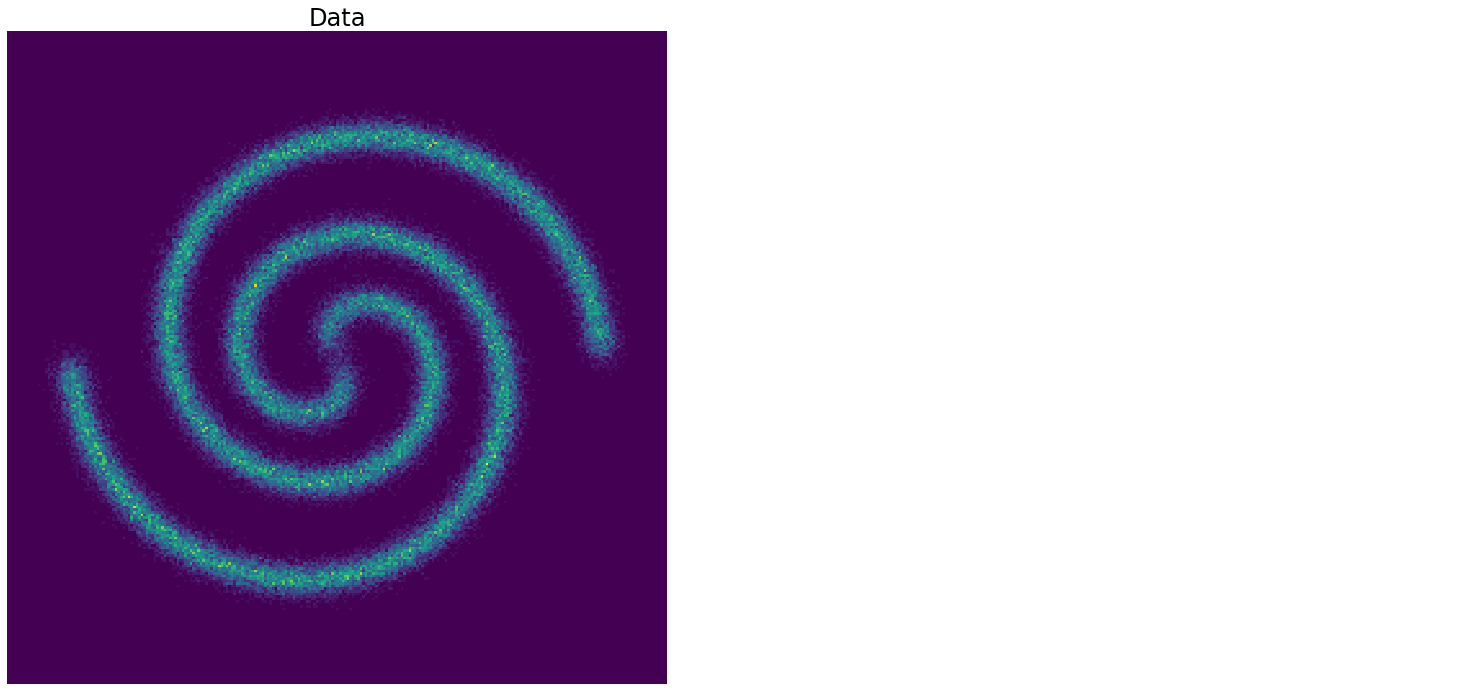

In [ ]:
import matplotlib.pyplot as plt

def plot_samples(s=None):
  d = test_loader.dataset.data.numpy()
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 12))
  ax[0].axis('off'); ax[1].axis('off')
  ax[0].set_title('Data', fontsize=24);
  ax[0].hist2d(d[...,0], d[...,1], bins=256, range=[[-4, 4], [-4, 4]])
  if s is not None:
    ax[1].set_title('Samples', fontsize=24)
    s = s.detach().cpu().numpy()
    ax[1].hist2d(s[...,0], s[...,1], bins=256, range=[[-4, 4], [-4, 4]])
  plt.show()

plot_samples()

# Create Model

In [ ]:
import torch
from torch import nn
from torch.distributions import Normal


class Flow(nn.Module):

    def __init__(self, bijections):
        super().__init__()
        self.bijections = nn.ModuleList(bijections)

    @property
    def base_dist(self):
        return Normal(
            loc=torch.zeros(2, device=device),
            scale=torch.ones(2, device=device),
        )

    def log_prob(self, x):
        log_prob = torch.zeros(x.shape[0], device=device)
        for bijection in self.bijections:
            x, ldj = bijection(x)
            log_prob += ldj
        log_prob += self.base_dist.log_prob(x).sum(1)
        return log_prob

    def sample(self, num_samples):
        with torch.no_grad():
            z = self.base_dist.sample((num_samples,))
            for bijection in reversed(self.bijections):
                z = bijection.inverse(z)
        return z


In [ ]:
# Implement Bijections

class Reverse(nn.Module):

    def forward(self, x):
        return x.flip(-1), x.new_zeros(x.shape[0])

    def inverse(self, z):
        return z.flip(-1)


class Coupling(nn.Module):
  
    def __init__(self, net):
        super().__init__()
        self.s, self.t = net

    def forward(self, x):
        '''z<-x transformation and ldj (log determinant Jacobian)'''
        # We chunk the input into two parts: x_a, x_b
        (xa, xb) = torch.chunk(x, 2, 1)

        s = self.s(xa)
        t = self.t(xa)
        
        za = xa
        zb =  torch.exp(s) * xb + t        

        z = torch.hstack([za, zb])

        ldj = torch.sum(s,-1) # s have only one dimension but taking sum (= this one value) returns the requested shape
        return z, ldj


    def inverse(self, z):
        ''' x<-z transformation'''
        # We chunk the input into two parts: z_a, z_b
        (za, zb) = torch.chunk(z, 2, 1)

        s = self.s(za)
        t = self.t(za)

        xa = za
        xb = (zb - t) * torch.exp(-s)   

        x = torch.hstack([xa, xb])
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def make_net():
# Neural networks for a single transformation (a single flow).
    M, D = 100, 2

    nets = nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                                nn.Linear(M, M), nn.LeakyReLU(),
                                nn.Linear(M, D // 2), nn.Tanh())

    nett = nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                                nn.Linear(M, M), nn.LeakyReLU(),
                                nn.Linear(M, D // 2))
    return nets, nett

flow = Flow([
  Coupling(make_net()), Reverse(),
  Coupling(make_net()), Reverse(),
  Coupling(make_net()), Reverse(),
  Coupling(make_net()),
]).to(device)

print(flow)

Flow(
  (bijections): ModuleList(
    (0): Coupling(
      (s): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Linear(in_features=100, out_features=1, bias=True)
        (5): Tanh()
      )
      (t): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Linear(in_features=100, out_features=1, bias=True)
      )
    )
    (1): Reverse()
    (2): Coupling(
      (s): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Lin

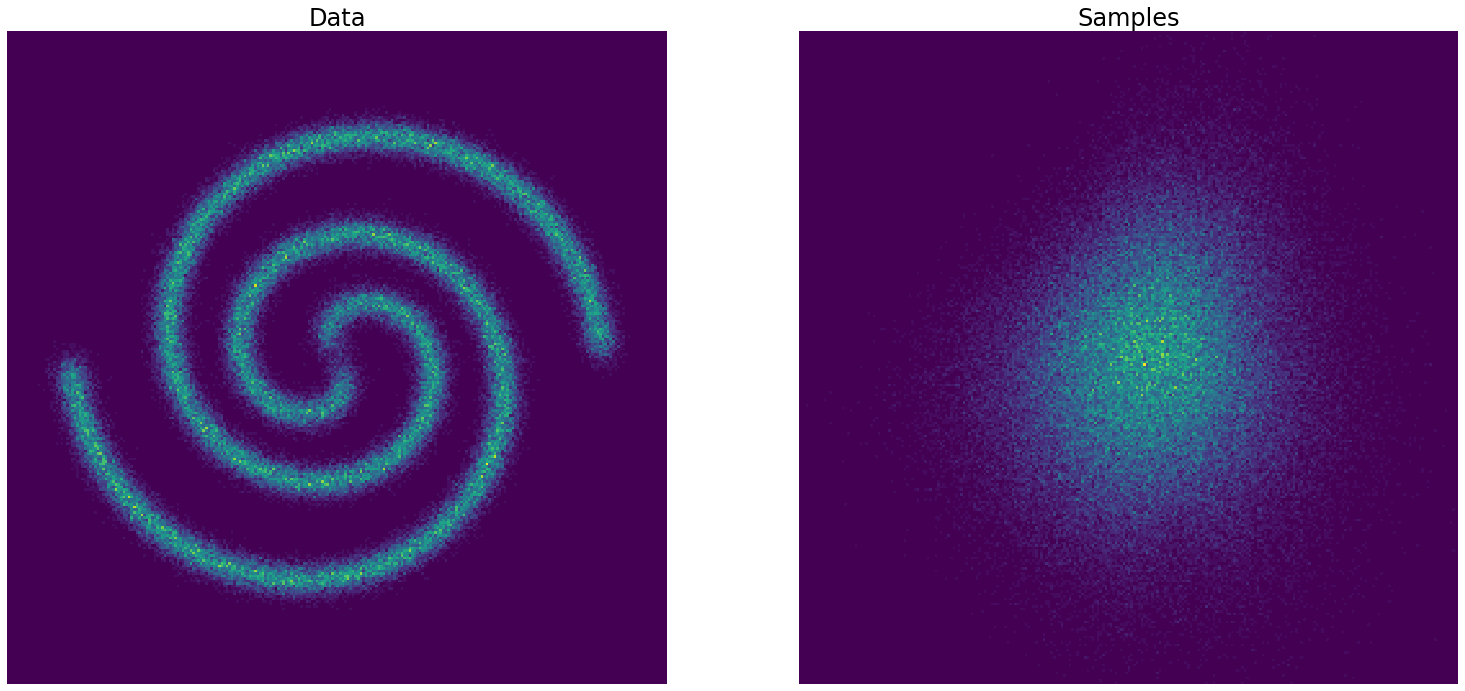

In [ ]:
# Plot model samples at initialization
plot_samples(flow.sample(128000))

# Train model

In [ ]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
epochs = 100

print('Training...')
flow = flow.train()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        loss = -flow.log_prob(x).mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_loader)))
flow = flow.eval()

Training...
Epoch: 1/100, Loss: 3.341
Epoch: 2/100, Loss: 3.159
Epoch: 3/100, Loss: 3.089
Epoch: 4/100, Loss: 3.066
Epoch: 5/100, Loss: 3.056
Epoch: 6/100, Loss: 3.049
Epoch: 7/100, Loss: 3.038
Epoch: 8/100, Loss: 3.030
Epoch: 9/100, Loss: 3.025
Epoch: 10/100, Loss: 3.021
Epoch: 11/100, Loss: 3.010
Epoch: 12/100, Loss: 3.007
Epoch: 13/100, Loss: 3.007
Epoch: 14/100, Loss: 3.001
Epoch: 15/100, Loss: 2.998
Epoch: 16/100, Loss: 2.994
Epoch: 17/100, Loss: 2.991
Epoch: 18/100, Loss: 2.989
Epoch: 19/100, Loss: 2.986
Epoch: 20/100, Loss: 2.987
Epoch: 21/100, Loss: 2.984
Epoch: 22/100, Loss: 2.977
Epoch: 23/100, Loss: 2.974
Epoch: 24/100, Loss: 2.972
Epoch: 25/100, Loss: 2.970
Epoch: 26/100, Loss: 2.968
Epoch: 27/100, Loss: 2.969
Epoch: 28/100, Loss: 2.958
Epoch: 29/100, Loss: 2.958
Epoch: 30/100, Loss: 2.955
Epoch: 31/100, Loss: 2.953
Epoch: 32/100, Loss: 2.955
Epoch: 33/100, Loss: 2.950
Epoch: 34/100, Loss: 2.950
Epoch: 35/100, Loss: 2.952
Epoch: 36/100, Loss: 2.950
Epoch: 37/100, Loss: 2.94

KeyboardInterrupt: ignored

In [ ]:
flow = flow.eval()

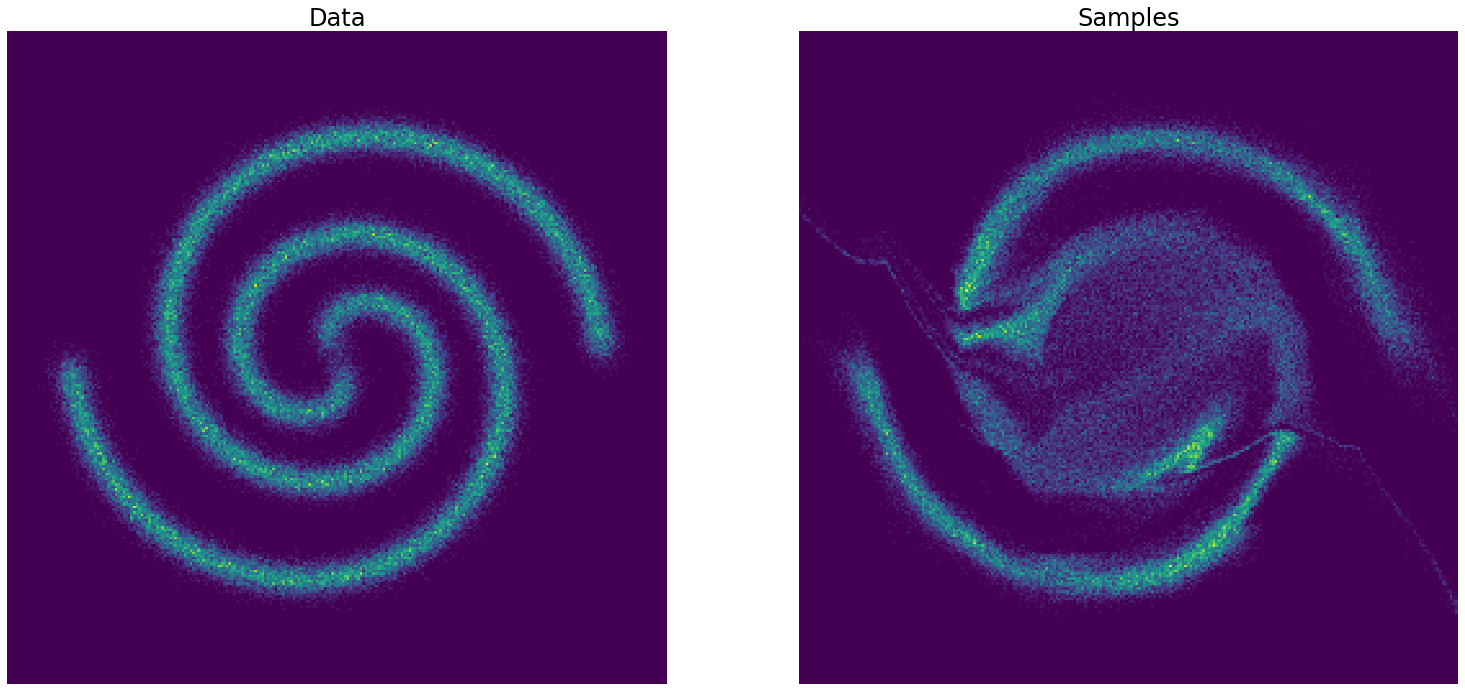

In [ ]:
# Plot model samples after training
plot_samples(flow.sample(128000))